In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Deepfake.zip -d Deepfake/

Archive:  /content/drive/MyDrive/Deepfake.zip
   creating: Deepfake/Deepfake dataset/
   creating: Deepfake/Deepfake dataset/Test/
   creating: Deepfake/Deepfake dataset/Test/fake/
  inflating: Deepfake/Deepfake dataset/Test/fake/fake_0.jpg  
  inflating: Deepfake/Deepfake dataset/Test/fake/fake_1.jpg  
  inflating: Deepfake/Deepfake dataset/Test/fake/fake_10.jpg  
  inflating: Deepfake/Deepfake dataset/Test/fake/fake_100.jpg  
  inflating: Deepfake/Deepfake dataset/Test/fake/fake_101.jpg  
  inflating: Deepfake/Deepfake dataset/Test/fake/fake_102.jpg  
  inflating: Deepfake/Deepfake dataset/Test/fake/fake_103.jpg  
  inflating: Deepfake/Deepfake dataset/Test/fake/fake_104.jpg  
  inflating: Deepfake/Deepfake dataset/Test/fake/fake_105.jpg  
  inflating: Deepfake/Deepfake dataset/Test/fake/fake_106.jpg  
  inflating: Deepfake/Deepfake dataset/Test/fake/fake_107.jpg  
  inflating: Deepfake/Deepfake dataset/Test/fake/fake_108.jpg  
  inflating: Deepfake/Deepfake dataset/Test/fake/fake_10

In [ ]:
pip install torch torchvision opencv-python-headless facenet-pytorch

INFO: pip is looking at multiple versions of facenet-pytorch to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.1 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import torch
from facenet_pytorch import MTCNN
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random

mtcnn = MTCNN()

/usr/local/lib/python3.10/dist-packages/facenet_pytorch/models/mtcnn.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(state_dict_path)
/usr/local

In [ ]:
from torchvision import transforms
from PIL import Image

class DeepfakeDataset(Dataset):
    def __init__(self, root_dir, transform=None, mtcnn=None):
        self.root_dir = root_dir
        self.transform = transform
        self.mtcnn = mtcnn
        self.image_paths = []
        self.labels = []

        # Populate the image paths and labels
        for label, class_dir in enumerate(['real', 'fake']):
            class_path = os.path.join(root_dir, class_dir)
            for img_name in os.listdir(class_path):
                self.image_paths.append(os.path.join(class_path, img_name))
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load the image
        image = Image.open(image_path).convert('RGB')

        # Detect and crop the face using MTCNN
        if self.mtcnn:
            image_cropped = self.mtcnn(image)

            # If no face was detected, return the next valid image recursively
            if image_cropped is None:
                return self.__getitem__((idx + 1) % len(self))

            # Convert the cropped tensor directly to a PIL Image
            image = transforms.ToPILImage()(image_cropped)

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

In [ ]:
extract_path = '/content/Deepfake'

In [ ]:
train_dir = os.path.join(extract_path, 'Deepfake dataset', 'Train')
val_dir = os.path.join(extract_path, 'Deepfake dataset', 'Validation')
test_dir = os.path.join(extract_path, 'Deepfake dataset', 'Test')

In [ ]:
train_dataset = DeepfakeDataset(root_dir=train_dir, transform=transform, mtcnn=mtcnn)
val_dataset = DeepfakeDataset(root_dir=val_dir, transform=transform, mtcnn=mtcnn)
test_dataset = DeepfakeDataset(root_dir=test_dir, transform=transform, mtcnn=mtcnn)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
for batch in train_loader:
    # Skip None results from failed face detections
    if batch is None:
        continue

    images, labels = batch
    print(images.shape, labels)
    # Add your training code here

torch.Size([32, 3, 128, 128]) tensor([0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1])
torch.Size([32, 3, 128, 128]) tensor([0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1,
        0, 1, 0, 0, 0, 0, 0, 0])


KeyboardInterrupt: 

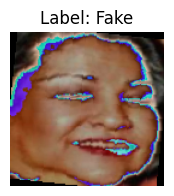

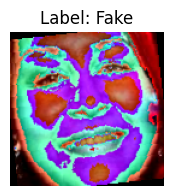

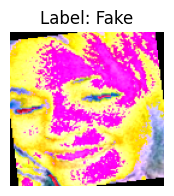

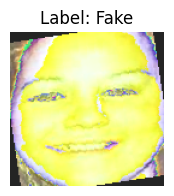

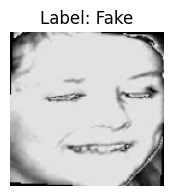

In [ ]:
import matplotlib.pyplot as plt

# Fetch the first 5 samples from the train loader
count = 0
for images, labels in train_loader:
    for i in range(len(images)):
        # Convert the tensor to a numpy array and display it
        img = images[i].permute(1, 2, 0).numpy()  # Change dimension order for display (C, H, W) -> (H, W, C)
        img = (img * 0.5 + 0.5).clip(0, 1)  # De-normalize if normalized to [-1, 1] range

        plt.figure(figsize=(2, 2))
        plt.imshow(img)
        plt.title(f"Label: {'Real' if labels[i].item() == 0 else 'Fake'}")
        plt.axis('off')
        plt.show()

        count += 1
        if count >= 5:
            break
    if count >= 5:
        break

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class DeepfakeCNN(nn.Module):
    def __init__(self):
        super(DeepfakeCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 16 * 16, 256)  # Assuming input size is 128x128
        self.fc2 = nn.Linear(256, 1)  # Binary classification (1 output neuron for real vs. fake)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = x.view(-1, 128 * 16 * 16)  # Flatten
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))  # Sigmoid for binary classification
        return x


In [ ]:
import torch

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model, loss function, and optimizer
model = DeepfakeCNN().to(device)
criterion = nn.BCELoss()  # Binary cross-entropy loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def calculate_accuracy(y_pred, y_true):
    y_pred = torch.round(y_pred)  # Round predictions to 0 or 1
    correct = (y_pred == y_true).float()
    return correct.sum() / len(correct)

# Training loop
num_epochs = 40
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_accuracy = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)  # Reshape labels for BCE loss

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate loss and accuracy
        train_loss += loss.item()
        train_accuracy += calculate_accuracy(outputs, labels)

    # Average loss and accuracy over the epoch
    train_loss /= len(train_loader)
    train_accuracy /= len(train_loader)

    # Validation step
    model.eval()
    val_loss = 0
    val_accuracy = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Calculate validation loss and accuracy
            val_loss += loss.item()
            val_accuracy += calculate_accuracy(outputs, labels)

    val_loss /= len(val_loader)
    val_accuracy /= len(val_loader)

    # Print epoch statistics
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Epoch [1/40], Train Loss: 0.7066, Train Accuracy: 0.4938, Validation Loss: 0.6932, Validation Accuracy: 0.4934
Epoch [2/40], Train Loss: 0.6957, Train Accuracy: 0.4896, Validation Loss: 0.6972, Validation Accuracy: 0.4934
Epoch [3/40], Train Loss: 0.6933, Train Accuracy: 0.5045, Validation Loss: 0.6947, Validation Accuracy: 0.4841
Epoch [4/40], Train Loss: 0.6869, Train Accuracy: 0.5357, Validation Loss: 0.6911, Validation Accuracy: 0.5038
Epoch [5/40], Train Loss: 0.6850, Train Accuracy: 0.5672, Validation Loss: 0.7017, Validation Accuracy: 0.5093
Epoch [6/40], Train Loss: 0.6800, Train Accuracy: 0.5653, Validation Loss: 0.6918, Validation Accuracy: 0.5132


In [ ]:
# prompt: test the above model using the test folder in dataset

# Testing loop
model.eval()
test_loss = 0
test_accuracy = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Calculate test loss and accuracy
        test_loss += loss.item()
        test_accuracy += calculate_accuracy(outputs, labels)

test_loss /= len(test_loader)
test_accuracy /= len(test_loader)

# Print test statistics
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.7197, Test Accuracy: 0.6058


In [ ]:
# Save the model
torch.save(model.state_dict(), 'deepfake_cnn.pth')
print("Model saved as 'deepfake_cnn.pth'")